In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, confusion_matrix, ConfusionMatrixDisplay,\
f1_score, precision_recall_curve, PrecisionRecallDisplay

import pickle
import os
import astropy
from astropy.io import fits
from time import process_time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### Extracting the telescope images from .FITS files

In [ ]:
# Example for opening a FITS file with Astropy and extracting the Header Data Unit (HDU)
# list object

hdul = fits.open(r'')
hdul.info

In [ ]:
# Header information containing the image description, details, and comments

hdul[0].header

In [ ]:
# Data containing a Numpy array of the image pixels

hdul[0].data

In [ ]:
# The numpy.dstack() function will be used to append all of the 2D
# image arrays into a 3D array of dimensions (51, 51, n), where n
# iis the number of images

arr1 = hdul[0].data
arr2 = np.dstack((arr1, arr1))

print(arr1.shape)
print(arr2.shape)

### Combining the images and labels via image ID

In [12]:
# Load the classifier labels (0 for supernova, 1 for no supernova)

data = pd.read_csv('autoscan_features.3.csv', skiprows = range(6))

In [15]:
# Load all of the difference image 2D arrays (accessed via hdul[0].data)
# using a for-loop

directory1 = r''
filenames = []
images1 = np.empty(shape = (51, 51), dtype = 'float32')

for filename in os.listdir(directory1):
    with fits.open(directory1 + '\\' + filename) as hdul:
        filenames.append(filename)
        images1 = np.dstack((images1, hdul[0].data))

In [16]:
# Load all of the template image 2D arrays (accessed via hdul[0].data)
# using a for-loop

directory2 = r''
images2 = np.empty(shape = (51, 51), dtype = 'float32')

for filename in os.listdir(directory2):
    with fits.open(directory2 + '\\' + filename) as hdul:
        images2 = np.dstack((images2, hdul[0].data))

In [17]:
# Load all of the search image 2D arrays (accessed via hdul[0].data)
# using a for-loop

directory3 = r''
images3 = np.empty(shape = (51, 51), dtype = 'float32')

for filename in os.listdir(directory3):
    with fits.open(directory3 + '\\' + filename) as hdul:
        images3 = np.dstack((images3, hdul[0].data))

In [18]:
# Delete the first d-stacked empty 2D array and check the final
# shape of the images 3D arrays

images1 = images1[:, :, 1:]
images2 = images2[:, :, 1:]
images3 = images3[:, :, 1:]

print(images1.shape)
print(images2.shape)
print(images3.shape)

(51, 51, 21639)
(51, 51, 21639)
(51, 51, 21639)


In [19]:
# Change the images IDs in the dataframe to match the FITS image filenames

diffs = []
temps = []
srchs = []

for num in data['ID']:
    diffs.append('diff' + str(num) + '.fits')
    temps.append('temp' + str(num) + '.fits')
    srchs.append('srch' + str(num) + '.fits')

In [20]:
# Set the 'ID' column to reflect the entire filename, for ease of mapping the filename to the
# correct label

data['Diffs_ID'] = diffs
data['Temps_ID'] = temps
data['Srchs_ID'] = srchs

In [21]:
# Only keep the relevant columns

data1 = data[['Diffs_ID', 'OBJECT_TYPE']]
data2 = data[['Temps_ID', 'OBJECT_TYPE']]
data3 = data[['Srchs_ID', 'OBJECT_TYPE']]

In [22]:
# Convert the dataframe to a list of dictionaries, where the IDs are the keys and
# the labels (object type) are the values

data_dict1 = data1.to_dict(orient = 'records')
data_dict2 = data2.to_dict(orient = 'records')
data_dict2 = data3.to_dict(orient = 'records')

In [23]:
# Add the corresponding labels (0 or 1) to a tuple, with the corresponding IDs

labels = []

for j in range(len(data_dict1)):
    if data_dict1[j]['Diffs_ID'] in filenames:
        labels.append((data_dict1[j]['Diffs_ID'],
                       data_dict1[j]['OBJECT_TYPE']))

In [24]:
# Rearrange the IDs and labels so that the order is the same as the list of filenames,
# which is the order that the 2D arrays of images were appended into the 3D images array

ordered_labels = []

for i in range(len(filenames)):
    for j in range(len(labels)):
        if filenames[i] == labels[j][0]:
            ordered_labels.append((labels[j][0], labels[j][1]))

In [25]:
# Check that the order is the same between the labels and filenames (images)

print(ordered_labels[:10])
print(filenames[:10])

[('diff10910985.fits', 0), ('diff10921299.fits', 1), ('diff10921304.fits', 0), ('diff10927330.fits', 0), ('diff10927339.fits', 1), ('diff10927479.fits', 1), ('diff10927629.fits', 0), ('diff10927637.fits', 1), ('diff10927932.fits', 0), ('diff10927980.fits', 0)]
['diff10910985.fits', 'diff10921299.fits', 'diff10921304.fits', 'diff10927330.fits', 'diff10927339.fits', 'diff10927479.fits', 'diff10927629.fits', 'diff10927637.fits', 'diff10927932.fits', 'diff10927980.fits']


In [26]:
# Now that the labels are in order, keep only the labels, and find out how
# many labels are 0 and 1 (the sum gives the number of labels that are 1)

final_labels = [label[1] for label in ordered_labels]
final_labels = np.array(final_labels)
print(final_labels.sum())

4686


In [27]:
# Combine the three different image channels, and normalize the
# Numpy array images so that they are ready to be fed into the CNN
# model

images1 = images1.reshape(len(filenames), 51, 51)
images2 = images2.reshape(len(filenames), 51, 51)
images3 = images3.reshape(len(filenames), 51, 51)

images1 = images1[:, np.newaxis, :, :]
images2 = images2[:, np.newaxis, :, :]
images3 = images3[:, np.newaxis, :, :]

images = np.concatenate((images1, images2, images3), axis = 1)
images = images / 255
print(images.shape)

(21639, 3, 51, 51)


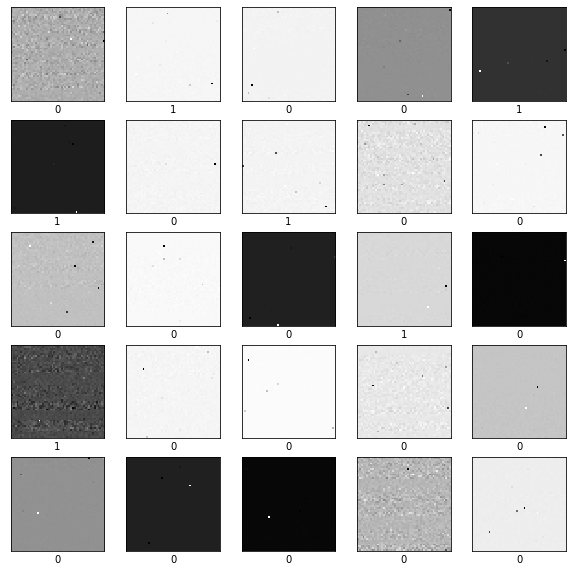

In [38]:
# Display the images

plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i, 0, :, :], cmap = plt.cm.binary)
    plt.xlabel(final_labels[i])
plt.show()

In [2]:
# Pickle the images and labels so that they will be easily loaded
# in the future

with open('2014_images.pkl', 'wb') as handle:
    pickle.dump(images, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('2014_labels.pkl', 'wb', compression = 'gzip') as handle:
    pickle.dump(final_labels, handle, protocol = pickle.HIGHEST_PROTOCOL)

### Load the pickled images dataset and labels here

In [3]:
# If running this Notebook in a new session, run the first cell of
# imports and then load the pickled data

with open('2014_images.pkl', 'rb') as handle:
    images = pickle.load(handle)
    
with open('2014_labels.pkl', 'rb') as handle:
    final_labels = pickle.load(handle)

In [28]:
# Split the image and target dataset into 80% training and 20% testing by indexing

indices = list(range(len(final_labels)))
train_indices, test_indices = train_test_split(indices, test_size = 0.2)

images_train = images[train_indices, :, :, :]
images_test = images[test_indices, :, :, :]

labels_train = final_labels[train_indices]
labels_test = final_labels[test_indices]

In [5]:
# Print shapes of training and test data to get the input shape required for CNN

print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(17311, 3, 51, 51)
(4328, 3, 51, 51)
(17311,)
(4328,)


### CNN model

#### Initial simple baseline CNN model

In [9]:
# Build the CNN model as a sequential layered structure, then
# summarize the model

network = Sequential()
network.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same',
                   input_shape = (3, 51, 51)))
network.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
network.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
network.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
network.add(Flatten())
network.add(Dense(512, activation = 'relu'))
network.add(Dense(1, activation = 'sigmoid'))
network.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 32)         14720     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 26, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 26, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 13, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               426496    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [10]:
# Fit the model to the training data

network.fit(images_train, labels_train, epochs = 100, batch_size = 32)

Epoch 1/100
541/541 [==============================] - 10s 17ms/step - loss: 0.8308 - accuracy: 0.7682
Epoch 2/100
541/541 [==============================] - 10s 18ms/step - loss: 0.5186 - accuracy: 0.7874
Epoch 3/100
541/541 [==============================] - 11s 19ms/step - loss: 0.5174 - accuracy: 0.7809
Epoch 4/100
541/541 [==============================] - 10s 18ms/step - loss: 0.5013 - accuracy: 0.7819
Epoch 5/100
541/541 [==============================] - 9s 17ms/step - loss: 0.4870 - accuracy: 0.7844
Epoch 6/100
541/541 [==============================] - 9s 17ms/step - loss: 0.4671 - accuracy: 0.7908
Epoch 7/100
541/541 [==============================] - 9s 17ms/step - loss: 0.4457 - accuracy: 0.7972
Epoch 8/100
541/541 [==============================] - 9s 17ms/step - loss: 0.4173 - accuracy: 0.8089
Epoch 9/100
541/541 [==============================] - 9s 16ms/step - loss: 0.3853 - accuracy: 0.8150
Epoch 10/100
541/541 [==============================] - 9s 17ms/step - loss: 0

In [11]:
# Generate predicted targets for the testing image data

labels_pred = network.predict_classes(images_test)

C:\Users\titan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [12]:
# Print the accuracy, precision, and recall scores of the
# predicted targets

print(accuracy_score(labels_test, labels_pred))
print(precision_score(labels_test, labels_pred))
print(recall_score(labels_test, labels_pred))

0.6767560073937153
0.2013986013986014
0.14814814814814814


In [13]:
# Save the model

network.save('base_model.h5')

In [14]:
# Load the previously saved model, and set the parameters
# to fixed values

base_model = keras.models.load_model('base_model.h5')
base_model.trainable = False

In [29]:
# Augment the CNN architecture by adding more
# adjustable parameters via transfer learning

model = Sequential([base_model,
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 460225    
_________________________________________________________________
flatten_3 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 460,227
Trainable params: 2
Non-trainable params: 460,225
_________________________________________________________________


In [30]:
# Fit this augmented model to the training data

history = model.fit(images_train, labels_train,
                    epochs=100,
                    batch_size=32)

Epoch 1/100
541/541 [==============================] - 3s 5ms/step - loss: 0.6699 - accuracy: 0.7832
Epoch 2/100
541/541 [==============================] - 3s 5ms/step - loss: 0.5372 - accuracy: 0.7846
Epoch 3/100
541/541 [==============================] - 3s 5ms/step - loss: 0.4505 - accuracy: 0.7857
Epoch 4/100
541/541 [==============================] - 3s 5ms/step - loss: 0.3894 - accuracy: 0.9320
Epoch 5/100
541/541 [==============================] - 3s 5ms/step - loss: 0.3477 - accuracy: 0.9336
Epoch 6/100
541/541 [==============================] - 2s 4ms/step - loss: 0.3183 - accuracy: 0.9326
Epoch 7/100
541/541 [==============================] - 2s 4ms/step - loss: 0.2979 - accuracy: 0.9312
Epoch 8/100
541/541 [==============================] - 2s 4ms/step - loss: 0.2740 - accuracy: 0.9342
Epoch 9/100
541/541 [==============================] - 3s 5ms/step - loss: 0.2651 - accuracy: 0.9318
Epoch 10/100
541/541 [==============================] - 3s 5ms/step - loss: 0.2623 - accura

In [32]:
# Generate predicted targets for the testing image data

labels_pred = model.predict_classes(images_test)

In [41]:
# Print the accuracy, precision, and recall scores of the
# predicted targets

print(accuracy_score(labels_test, labels_pred))
print(precision_score(labels_test, labels_pred))
print(recall_score(labels_test, labels_pred))
print(f1_score(labels_test, labels_pred))

0.9265249537892791
0.8464961067853171
0.8087141339001063
0.8271739130434782
